In [56]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

from tsmoothie.smoother import *

import warnings
warnings.simplefilter('ignore')
from tslearn.clustering import TimeSeriesKMeans
from tslearn.preprocessing import TimeSeriesScalerMinMax

In [57]:
### READ DATA ###

df = pd.read_csv('financial_data_2000_2018_cleaned.csv.zip', index_col=0)
df['timestamp'] = df.timestamp.apply(datetime.fromtimestamp)
df = df.loc[df.timestamp.dt.year > 2014].copy()
df.sort_values(['stock','timestamp'], inplace=True)

print(df.shape)
df.head()

(35139, 7)


,stock,timestamp,open,high,low,adj_close,volume
9960,AAPL,2015-01-02 07:00:00,104.25,104.29,104.29,102.32,53204626
9959,AAPL,2015-01-05 07:00:00,101.35,101.68,101.68,99.44,64285491
9958,AAPL,2015-01-06 07:00:00,99.71,100.54,100.54,99.45,65797116
9957,AAPL,2015-01-07 07:00:00,100.33,101.26,101.26,100.84,40105934
9956,AAPL,2015-01-08 07:00:00,102.23,104.96,104.96,104.72,59364547


In [58]:
### MANAGE CLOSE PRICES (STOCKS, TIMESTEMPS) ###

df_close = df.set_index(['stock','timestamp'])['adj_close'].unstack()
df_close = df_close.loc[~df_close.isna().any(axis=1)].copy()
df_close.columns = range(len(df_close.columns))

df_close.head(10)

,0,1,2,3,4,5,6,7,8,9,...,891,892,893,894,895,896,897,898,899,900
stock,,,,,,,,,,,,,,,,,,,,,
AAPL,102.32,99.44,99.45,100.84,104.72,104.83,102.24,103.15,102.76,99.97,...,189.73,191.21,190.77,190.94,192.33,194.14,193.53,190.31,189.25,189.63
ADBE,72.34,71.98,70.53,71.11,72.92,71.84,71.12,70.59,69.99,70.29,...,259.78,257.68,257.54,259.47,257.49,263.17,261.93,254.81,242.32,244.68
ADSK,59.53,58.66,57.50,57.38,58.80,58.27,57.29,57.34,56.41,55.71,...,137.43,134.50,134.32,134.50,132.31,135.85,136.14,131.16,127.00,128.44
AKRX,36.07,37.12,36.42,38.16,40.28,40.72,40.51,41.28,41.74,40.46,...,16.85,17.31,17.47,17.27,16.98,17.49,17.60,18.23,18.31,18.52
AMAT,23.59,22.83,21.97,22.18,22.88,22.91,22.36,22.05,21.75,22.04,...,48.06,46.46,46.55,46.22,45.70,45.75,46.95,48.08,47.69,48.41
AMZN,308.52,302.19,295.29,298.42,300.46,296.93,291.41,294.74,293.27,286.95,...,1842.92,1812.97,1813.70,1802.00,1829.24,1863.61,1808.00,1817.27,1779.22,1777.44
ATVI,19.54,19.27,18.91,18.50,18.69,18.35,18.31,18.02,18.38,18.01,...,81.27,80.61,79.65,79.75,78.41,79.45,77.65,75.36,72.75,73.42
BBBY,73.57,72.73,72.32,74.99,76.18,71.04,70.40,71.10,71.10,69.19,...,18.72,19.23,18.78,19.17,19.04,18.86,18.99,18.82,19.40,18.73
BIDU,223.08,219.79,220.18,224.35,229.21,226.90,220.89,219.60,216.82,215.97,...,269.42,262.42,259.98,260.38,256.48,262.91,260.35,255.09,251.40,247.18


In [59]:
### SMOOTH PRICE ###

window_shape = 20

smoother = WindowWrapper(LowessSmoother(smooth_fraction=0.6, iterations=1), 
                         window_shape=window_shape)
smoother.smooth(df_close.loc['AMZN'])

low, up = smoother.get_intervals('prediction_interval') # only for visualization

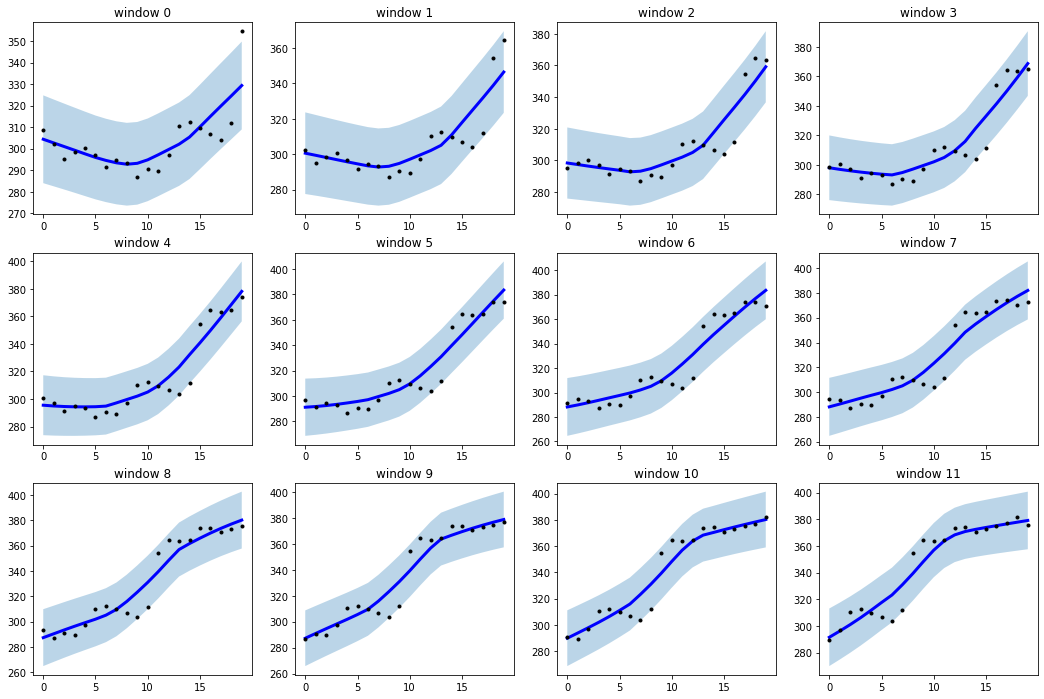

In [60]:
### PLOT THE FIRST 12 SMOOTHED WINDOWS ###

plt.figure(figsize=(18,12))

for i,(true,smooth) in enumerate(zip(smoother.Smoother.data, smoother.Smoother.smooth_data)):
    
    if i == 12:
        break
    
    plt.subplot(3,4, i+1)
    plt.plot(smooth, linewidth=3, color='blue')
    plt.plot(true, '.k')
    plt.fill_between(range(len(true)), low[i], up[i], alpha=0.3)
    plt.title(f"window {i}")

In [61]:
### SCALE SMOOTHED WINDOWS ###

smooth_scaled = TimeSeriesScalerMinMax().fit_transform(smoother.Smoother.smooth_data)
smooth_scaled.shape

(882, 20, 1)

In [62]:
### CLUSTER SMOOTHED WINDOWS ###

smooth_km = TimeSeriesKMeans(n_clusters=4, metric="dtw", max_iter=10, random_state=33)
smooth_km.fit(smooth_scaled)

TimeSeriesKMeans(max_iter=10, metric='dtw', n_clusters=4, random_state=33)

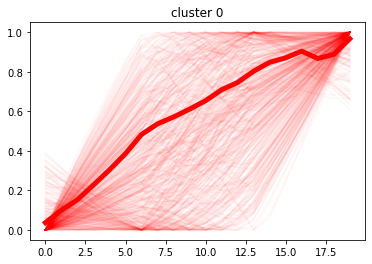

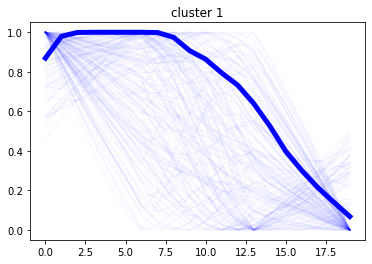

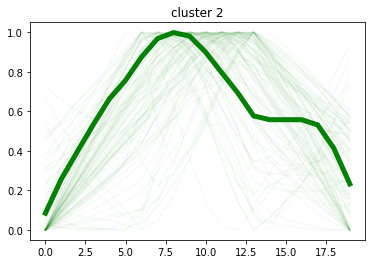

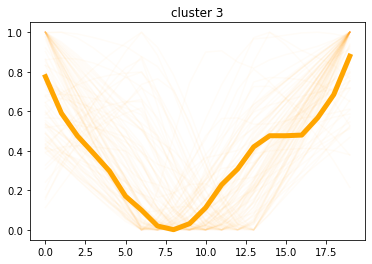

In [63]:
### PLOT CLUSTER CENTERS WITH SAMPLES ###

colors = {0:'red',1:'blue',2:'green',3:'orange'}

for c in range(smooth_km.n_clusters):
    
    plt.plot(np.squeeze(smooth_scaled[smooth_km.labels_ == c],-1).T, c=colors[c], alpha=0.03)
    plt.plot(np.squeeze(smooth_km.cluster_centers_, -1)[c], c=colors[c], linewidth=5)
    plt.title(f"cluster {c}")
    
    plt.show()

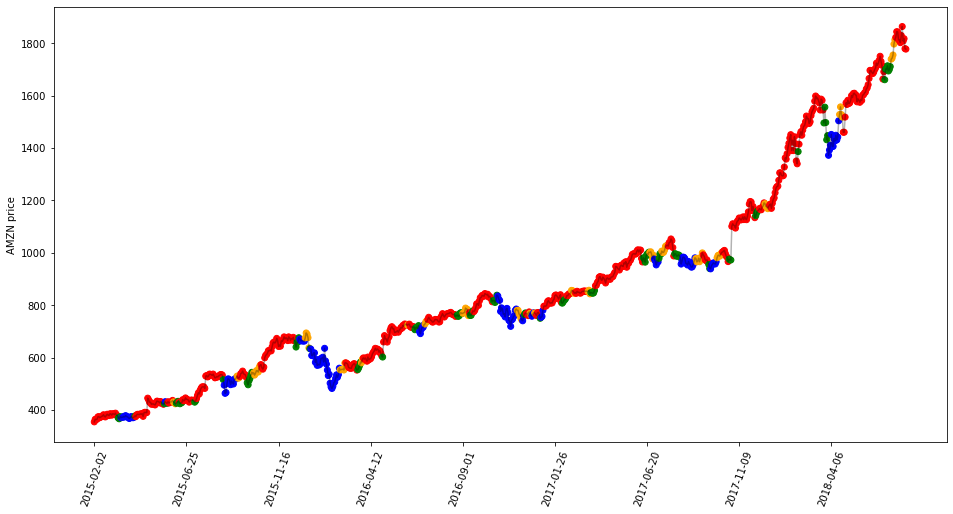

In [64]:
### PLOT CLUSTER ON THE RAW TIME SERIES ###

plt.figure(figsize=(16,8))

plt.plot(smoother.Smoother.data[:,-1], c='black', alpha=0.3)
plt.scatter(range(len(smoother.Smoother.data[:,-1])), smoother.Smoother.data[:,-1], 
            c=[colors[c] for c in smooth_km.labels_])

plt.xticks(range(0,len(df.timestamp.unique())-window_shape, 100), 
           df.timestamp.dt.date.unique()[window_shape::100], rotation=70)
plt.ylabel('AMZN price')
np.set_printoptions(False)

In [65]:
### SCALE RAW WINDOWS ###

raw_scaled = TimeSeriesScalerMinMax().fit_transform(smoother.Smoother.data)
raw_scaled.shape

(882, 20, 1)

In [66]:
### CLUSTER RAW WINDOWS ###

raw_km = TimeSeriesKMeans(n_clusters=4, metric="dtw", max_iter=10, random_state=33)
raw_km.fit(raw_scaled)

TimeSeriesKMeans(max_iter=10, metric='dtw', n_clusters=4, random_state=33)

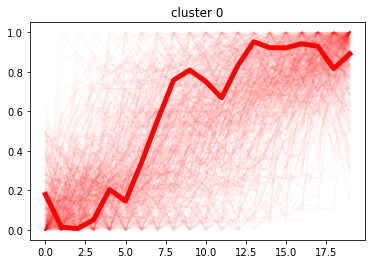

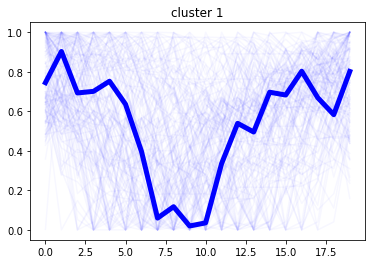

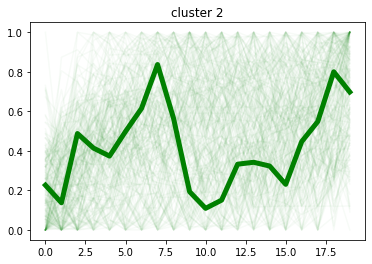

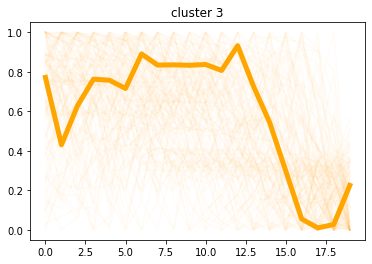

In [67]:
### PLOT CLUSTER CENTERS WITH SAMPLES ###

colors = {0:'red',1:'blue',2:'green',3:'orange'}

for c in range(raw_km.n_clusters):
    
    plt.plot(np.squeeze(raw_scaled[raw_km.labels_ == c],-1).T, c=colors[c], alpha=0.03)
    plt.plot(np.squeeze(raw_km.cluster_centers_, -1)[c], c=colors[c], linewidth=5)
    plt.title(f"cluster {c}")
    
    plt.show()

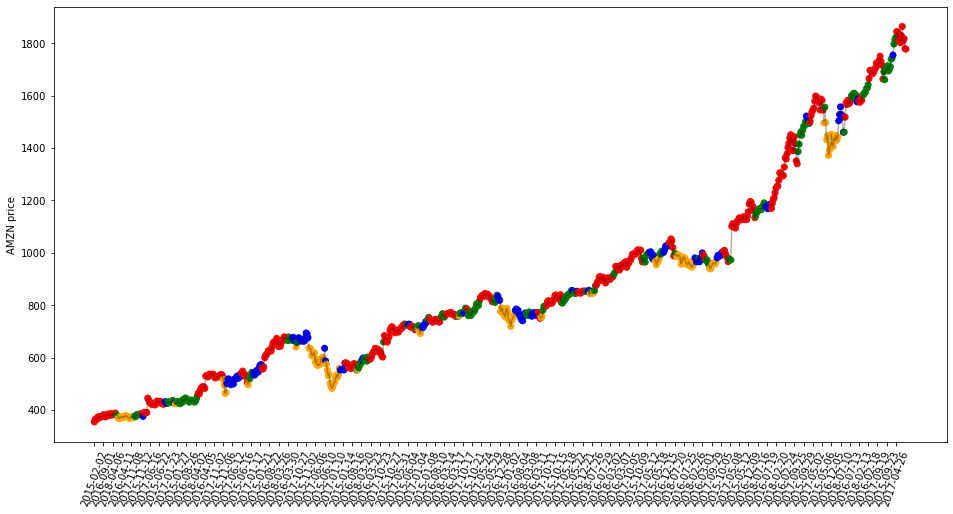

In [79]:
### PLOT CLUSTER ON THE RAW TIME SERIES ###

colors = {0:'red',1:'blue',2:'green',3:'orange'}

plt.figure(figsize=(16,8))
plt.plot(smoother.Smoother.data[:,-1], c='black', alpha=0.3)
plt.scatter(range(len(smoother.Smoother.data[:,-1])), smoother.Smoother.data[:,-1], 
            c=[colors[c] for c in raw_km.labels_])

plt.xticks(range(0,len(df.timestamp.unique())-window_shape-10, 10), 
           df.timestamp[window_shape::400].dt.date.unique(), rotation=70)
plt.ylabel('AMZN price')
np.set_printoptions(False)